In [15]:
import pickle
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.stats as stats

import figures

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Acknowledgement

Thanks to [J. Walton's post](https://jwalton.info/Embed-Publication-Matplotlib-Latex/)---instructions for pdf-perfect plots from matplotlib.

Thanks to Sihan for writing the code to plot the IGT data.

## Load the data

In [14]:
def load(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

stability_data = load('data/stability-data.pkl')
igt_data       = load('data/igt-data.pkl')
xigt_data      = load('data/xigt-data.pkl')

### Set the style and layout

In [18]:
TEXT_WIDTH_PT = 247.94499
EXTRA_INCHES  = 0.5

def subplots(rows, cols, transpose_titles=False, wspace=0.06, hspace=0.12, x=0.12, y=0.65, **kwargs):
    pt = TEXT_WIDTH_PT + figures.inches_to_pt(EXTRA_INCHES)
    fig, axes = figures.subplots(rows, cols, pt, **kwargs)
    figures.title_subplots(axes.T if transpose_titles else axes, x=x, y=y)
    plt.subplots_adjust(hspace=hspace, wspace=wspace)
    return fig, axes

In [19]:
c = plt.cm.plasma
GRAY   = "gray"
PURPLE = c(0.0)
ORANGE = c(0.65)
print("purple", PURPLE)
print("orange", ORANGE)

figures.use_tex_params()

purple (0.050383, 0.029803, 0.527975, 1.0)
orange (0.918109, 0.453603, 0.339529, 1.0)


Creating 4 by 2 subplots, (3.930814860938149, 4.858754375085935) inches.


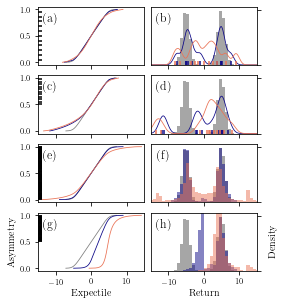

In [20]:
fig, axes = subplots(4, 2, sharex='col', sharey='col', wspace=0.06, hspace=0.18)

all_samples = np.concatenate(
    [stability_data[k][t]['sample']
         for k in ['opt-based imputer', 'opt-based imputer (half)',
                   'direct imputer',    'direct imputer (half)'   ]
         for t in [0, 50]
    ]
)

s_range = all_samples.min(), all_samples.max()
support = np.linspace(*s_range, 500)
bins =  np.linspace(*s_range, 50)

for i, k in enumerate(['opt-based imputer', 'opt-based imputer (half)',
                       'direct imputer',    'direct imputer (half)'   ]):
    log = stability_data[k]
    # expectiles
    axes[i, 0].plot(*log[0]['minor_expectiles'], color="gray", linewidth=0.8)
    taus = log[0]['major_expectiles'][1]
    axes[i, 0].scatter(np.full_like(taus, -14.3), taus,
                       marker="_", color="black", zorder=10, s=15)
    # samples
    axes[i, 1].yaxis.set_label_position("right")
    axes[i, 1].yaxis.tick_right()
    axes[i, 1].hist(log[0]['sample'], density=True, bins=bins, alpha=0.7, color="gray")
    for t, color in [(1, PURPLE), (50, ORANGE)]:
        axes[i, 0].plot(*log[t]['minor_expectiles'], color=color, linewidth=0.8)
        if i < 2:
            kd = stats.gaussian_kde(log[t]['sample'], bw_method=0.18)
            axes[i, 1].plot(support, kd.pdf(support), color=color, linewidth=0.8)
            axes[i, 1].scatter(log[t]['sample'], np.full_like(log[1]['sample'], 0.006),
                               marker="|", color=color, zorder=10, s=10)
        else:
            axes[i, 1].hist(log[t]['sample'], density=True, bins=bins, alpha=0.5,
                           color=color)

axes[i, 0].set_xlim([-15, 15])
axes[i, 0].set_yticks([0, 0.5, 1])
axes[i, 0].set_ylabel("Asymmetry")
axes[i, 0].set_xlabel("Expectile")

axes[i, 1].set_ylim([0, 0.2])
axes[i, 1].set_xlim([-15, 15])
axes[i, 1].set_yticks([0, 0.19])
axes[i, 1].set_yticklabels([])
axes[i, 1].set_ylabel("Density")
axes[i, 1].set_xlabel("Return")

plt.savefig('plots/stability.pdf', bbox_inches='tight')
plt.show()

### Plot the igt data

Creating 3 by 2 subplots, (3.930814860938149, 3.6440657813144512) inches.


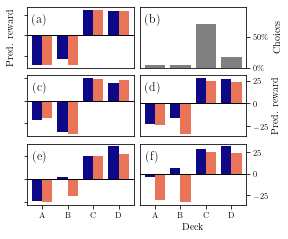

In [21]:
def plot_multi_bars(axis, heights, colors):
    N, K = heights.shape
    # make plots
    # prepare offsets
    xs = np.arange(0, N)
    os,h = np.linspace(-.4, .4, K, endpoint=False, retstep=True)
    os += h/2
    # add bars
    for i, hs in enumerate(heights):
        axis.bar(xs[i] + os, hs, h, color=colors)
    axis.axhline(linewidth=1, color='black')

def transform(data):
    return np.array([
        [data['A1'], data['A2']],
        [data['B1'], data['B2']],
        [data['C1'], data['C2']],
        [data['D1'], data['D2']],
    ])

fig, axes = subplots(3, 2, sharey=False)

for ax in axes[:, -1]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
for ax in axes[:, 0]:
    ax.set_yticklabels([])
for ax in axes[:-1, :].flat:
    ax.set_xticklabels([])
    ax.tick_params(axis='x', which=u'both',length=0)
axes[0, 0].set_ylabel("Pred. reward")
axes[0, 1].set_ylabel("Choices")
axes[1, 1].set_ylabel("Pred. reward")
axes[2, 0].set_xticks([0, 1, 2, 3])
axes[2, 0].set_xticklabels(['A', 'B', 'C', 'D'])
axes[2, 1].set_xticks([0, 1, 2, 3])
axes[2, 1].set_xticklabels(['A', 'B', 'C', 'D'])
axes[2, 1].set_xlabel("Deck")

# plot the action counts
axes[0, 1].set_ylim(0, 0.99)
axes[0, 1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axes[0, 1].set_yticks([0, 0.5])
counts = np.atleast_2d(igt_data['traditional action counts'])
counts = (counts / counts.sum()).T
plot_multi_bars(axes[0, 1], counts, GRAY)

# plot the state values
plot_multi_bars(axes[0, 0], transform(igt_data['traditional']),      [PURPLE, ORANGE])
plot_multi_bars(axes[1, 0], transform(igt_data['opt-based']),        [PURPLE, ORANGE])
plot_multi_bars(axes[1, 1], transform(igt_data['opt-based (half)']), [PURPLE, ORANGE])
plot_multi_bars(axes[2, 0], transform(igt_data['direct']),           [PURPLE, ORANGE])
plot_multi_bars(axes[2, 1], transform(igt_data['direct (half)']),    [PURPLE, ORANGE])

plt.savefig('plots/igt.pdf', bbox_inches='tight')
plt.show()

Creating 2 by 2 subplots, (3.930814860938149, 2.4293771875429675) inches.


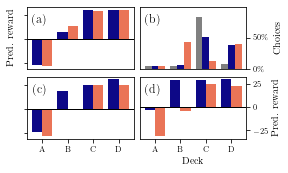

In [22]:
fig, axes = subplots(2, 2, sharey=False)

# for all plot on the right, tick right
for ax in axes[:, -1]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
for ax in axes[:, 0]:
    ax.set_yticklabels([])
for ax in axes[:-1, :].flat:
    ax.set_xticklabels([])
    ax.tick_params(axis='x', which=u'both',length=0)
axes[0, 0].set_ylabel("Pred. reward")
axes[0, 1].set_ylabel("Choices")
axes[1, 1].set_ylabel("Pred. reward")
axes[1, 0].set_xticks([0, 1, 2, 3])
axes[1, 0].set_xticklabels(['A', 'B', 'C', 'D'])
axes[1, 1].set_xticks([0, 1, 2, 3])
axes[1, 1].set_xticklabels(['A', 'B', 'C', 'D'])
axes[1, 1].set_xlabel("Deck")

# plot the action counts

axes[0, 1].set_ylim(0, 0.99)
axes[0, 1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axes[0, 1].set_yticks([0, 0.5])
counts = np.stack([xigt_data['traditional action counts'],
                     xigt_data['direct action counts'],
                     xigt_data['direct (half) action counts']])
counts = (counts / counts.sum(axis=1, keepdims=True)).T
plot_multi_bars(axes[0, 1], counts, ['gray', c(0), c(0.65)])

# plot the state values
plot_multi_bars(axes[0, 0], transform(xigt_data['traditional']),   [PURPLE, ORANGE])
plot_multi_bars(axes[1, 0], transform(xigt_data['direct']),        [PURPLE, ORANGE])
plot_multi_bars(axes[1, 1], transform(xigt_data['direct (half)']), [PURPLE, ORANGE])

plt.savefig('plots/xigt.pdf', bbox_inches='tight')
plt.show()

In [23]:
# TODO: Online expectiles and learning rate stability